### Overview
The data has been split into two groups:<br>

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.<br>

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.<br>

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.<br>

### Data Dictionary

| Variable | Definition | Key |
| :- | :- | :- |
|survival | Survival | 0 = No, 1 = Yes |
|pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex |  |	
|Age | Age in years |  |	
|sibsp | # of siblings / spouses aboard the Titanic |  |
|parch | # of parents / children aboard the Titanic |  |
|ticket | Ticket number |  |
|fare | Passenger fare |  |
|cabin | Cabin number |  |
|embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes<br>
pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>

parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, f1_score, log_loss, matthews_corrcoef
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
dfDesc = []

for i in df.columns:
        dfDesc.append([i, df[i].dtypes, df[i].isna().sum(), round((((df[i].isna().sum())/(len(df)))*100),2), 
                    df[i].nunique(), df[i].drop_duplicates().sample(2).values])
pd.DataFrame(dfDesc, columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,PassengerId,int64,0,0.00,891,"[38, 256]"
1,Survived,int64,0,0.00,2,"[0, 1]"
2,Pclass,int64,0,0.00,3,"[2, 3]"
3,Name,object,0,0.00,891,"[Lemberopolous, Mr. Peter L, Rothes, the Count..."
4,Sex,object,0,0.00,2,"[male, female]"
5,Age,float64,177,19.87,88,"[11.0, 23.0]"
6,SibSp,int64,0,0.00,7,"[1, 5]"
7,Parch,int64,0,0.00,7,"[5, 1]"
8,Ticket,object,0,0.00,681,"[363294, 113059]"
9,Fare,float64,0,0.00,248,"[12.275, 25.9292]"


Note :
- There are missing values in Age, Cabin, and Embarked
- PassengerId and Name should be dropped because it makes no sense for them to contribute wether a passenger will survive or not

### 1. Data Cleansing

In [4]:
df_test = pd.read_csv('test.csv')
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [14]:
df_all = pd.concat([df.drop(columns=['Survived']), df_test], ignore_index=True)

In [17]:
df_all.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
df_all.set_index('PassengerId', inplace=True)

In [23]:
df_all

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [24]:
dfDesc = []

for i in df_test.columns:
        dfDesc.append([i, df_test[i].dtypes, df_test[i].isna().sum(), round((((df_test[i].isna().sum())/(len(df_test)))*100),2), 
                    df_test[i].nunique(), df_test[i].drop_duplicates().sample(2).values])
pd.DataFrame(dfDesc, columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,PassengerId,int64,0,0.00,418,"[1194, 1244]"
1,Pclass,int64,0,0.00,3,"[2, 1]"
2,Name,object,0,0.00,418,"[Elias, Mr. Joseph, McCrie, Mr. James Matthew]"
3,Sex,object,0,0.00,2,"[male, female]"
4,Age,float64,86,20.57,79,"[22.5, 13.0]"
5,SibSp,int64,0,0.00,7,"[4, 0]"
6,Parch,int64,0,0.00,8,"[5, 1]"
7,Ticket,object,0,0.00,363,"[29105, PC 17608]"
8,Fare,float64,1,0.24,169,"[39.6, 42.5]"
9,Cabin,object,327,78.23,76,"[C106, C54]"


In [25]:
dfDesc = []

for i in df_all.columns:
        dfDesc.append([i, df_all[i].dtypes, df_all[i].isna().sum(), round((((df_all[i].isna().sum())/(len(df_all)))*100),2), 
                    df_all[i].nunique(), df_all[i].drop_duplicates().sample(2).values])
pd.DataFrame(dfDesc, columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Pclass,int64,0,0.00,3,"[3, 1]"
1,Name,object,0,0.00,1307,"[McNamee, Mr. Neal, Beane, Mr. Edward]"
2,Sex,object,0,0.00,2,"[female, male]"
3,Age,float64,263,20.09,98,"[38.5, 30.5]"
4,SibSp,int64,0,0.00,7,"[3, 8]"
5,Parch,int64,0,0.00,8,"[6, 1]"
6,Ticket,object,0,0.00,929,"[364499, 348122]"
7,Fare,float64,1,0.08,281,"[13.8583, 9.325]"
8,Cabin,object,1014,77.46,186,"[C123, D35]"
9,Embarked,object,2,0.15,3,"[nan, S]"


Both train and test data are missing 20% of their Age value. We could try predicting missing Ages using linear regression<br>

It seems the first letter Cabin value indicates the deck. For now, let's fill the missing values with a string 'Missing'

In [26]:
df_all['Cabin'].fillna(value='Missing', inplace=True)


In [27]:
df_all['Cabin'] = df_all['Cabin'].apply(lambda x: x[0])

In [28]:
list_index_nullFare = df_all[df_all['Fare'].isnull()].index.tolist()
list_index_nullFare

[1044]

In [29]:
df_all.drop(index=list_index_nullFare, axis=0, inplace=True)

In [30]:
df_age_notnull = df_all[df_all['Age'].notna()].copy()
df_age_notnull

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S
...,...,...,...,...,...,...,...,...,...,...
1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,M,S
1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C,Q
1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,M,S


In [31]:
df_age_null = df_all[df_all['Age'].isna()].copy()
df_age_null

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,M,Q
18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,M,S
20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,M,C
27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,M,C
29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,M,Q
...,...,...,...,...,...,...,...,...,...,...
1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,M,Q
1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,M,Q
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,M,S


In [33]:
df_age_notnull.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_age_null.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [34]:
df_age_notnull_ohe = pd.get_dummies(df_age_notnull, drop_first=True)
df_age_null_ohe = pd.get_dummies(df_age_null, drop_first=True)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_age_notnull_ohe.drop(columns=['Age']), df_age_notnull_ohe[['Age']], test_size = 0.2, random_state = 101)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

lm = LinearRegression()
search_lm = GridSearchCV(estimator = lm,
                         param_grid = {
                         'normalize' : [False, True]},
                         scoring = 'neg_root_mean_squared_error',
                         cv = 10,
                         n_jobs = -1)

In [38]:
search_lm.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'normalize': [False, True]},
             scoring='neg_root_mean_squared_error')

In [39]:
import statsmodels.api as sm
from statsmodels.api import OLS

sm_lm = OLS(y_train, sm.add_constant(X_train))
result = sm_lm.fit()

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     33.40
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           4.77e-41
Time:                        14:12:58   Log-Likelihood:                -3299.4
No. Observations:                 836   AIC:                             6615.
Df Residuals:                     828   BIC:                             6653.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3603      1.867     23.757      0.000      40.695      48.025
Pclass        -7.0764      0.654    -10.827      0.000      -8.359      -5.794
SibSp         -2.9238      0.524     -5.577      0.000      -3.953      -1.895
Parch         -0.8033      0.572     -1.404      0.161      -1.927       0.320
Fare           0.0076      0.010      0.794      0.428      -0.011       0.026
Sex_male       2.3201      0.940      2.467      0.014       0.474       4.166
Embarked_Q     3.2974      2.366      1.394      0.164      -1.346       7.941
Embarked_S     1.2803      1.163      1.101      0.271      -1.003       3.564
==============================================================================
Omnibus:                       21.433   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.249
Skew:                           0.352   Prob(JB):                     8.94e-06
Kurtosis:                       3.413   Cond. No.                         394.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'predicted Y')

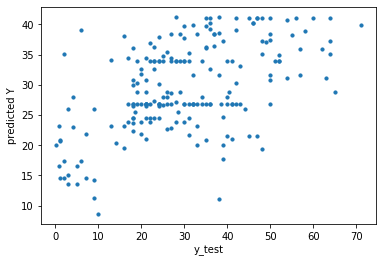

In [41]:
predictions = search_lm.predict(X_test)
plt.scatter(y_test, predictions, s=10)
plt.xlabel('y_test')
plt.ylabel('predicted Y')

In [42]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test,predictions))

MAE: 10.33296562020043
MSE: 165.11214795736603
RMSE: 12.849597190471226
R2 Score: 0.28115863262732443


In [43]:
df_age_null_ohe['PredictedAge'] = search_lm.predict(df_age_null_ohe.drop(['Age'], axis=1))

In [44]:
df_age_null_ohe

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,PredictedAge
PassengerId,,,,,,,,,
6,3,NaN,0,0,8.4583,1,1,0,28.813088
18,2,NaN,0,0,13.0000,1,0,1,33.906972
20,3,NaN,0,0,7.2250,0,0,0,23.186170
27,3,NaN,0,0,7.2250,1,0,0,25.506290
29,3,NaN,0,0,7.8792,0,1,0,26.488557
...,...,...,...,...,...,...,...,...,...
1300,3,NaN,0,0,7.7208,0,1,0,26.487351
1302,3,NaN,0,0,7.7500,0,1,0,26.487573
1305,3,NaN,0,0,8.0500,1,0,1,26.792872


In [48]:
df.set_index('PassengerId', inplace=True)

In [53]:
train_id_null = df[df['Age'].isnull()].index.to_list()

In [54]:
predict_train = df_age_null_ohe.loc[train_id_null]
predict_train

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,PredictedAge
PassengerId,,,,,,,,,
6,3,NaN,0,0,8.4583,1,1,0,28.813088
18,2,NaN,0,0,13.0000,1,0,1,33.906972
20,3,NaN,0,0,7.2250,0,0,0,23.186170
27,3,NaN,0,0,7.2250,1,0,0,25.506290
29,3,NaN,0,0,7.8792,0,1,0,26.488557
...,...,...,...,...,...,...,...,...,...
860,3,NaN,0,0,7.2292,1,0,0,25.506322
864,3,NaN,8,2,69.5500,0,0,1,-0.055520
869,3,NaN,0,0,9.5000,1,0,1,26.803916


In [55]:
df.loc[predict_train.index.tolist(), 'Age'] = predict_train['PredictedAge']

In [58]:
df_test.set_index('PassengerId', inplace=True)

In [59]:
test_id_null = df_test[df_test['Age'].isnull()].index.to_list()
predict_test = df_age_null_ohe.loc[test_id_null]
predict_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,PredictedAge
PassengerId,,,,,,,,,
902,3,NaN,0,0,7.8958,1,0,1,26.791697
914,1,NaN,0,0,31.6833,0,0,1,38.805553
921,3,NaN,2,0,21.6792,1,0,0,19.768845
925,3,NaN,1,2,23.4500,0,0,1,20.059733
928,3,NaN,0,0,8.0500,0,0,1,24.472752
...,...,...,...,...,...,...,...,...,...
1300,3,NaN,0,0,7.7208,0,1,0,26.487351
1302,3,NaN,0,0,7.7500,0,1,0,26.487573
1305,3,NaN,0,0,8.0500,1,0,1,26.792872


In [60]:
df_test.loc[predict_test.index.tolist(), 'Age'] = predict_test['PredictedAge']

In [62]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,26.792872,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [63]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,20.059733,1,2,W./C. 6607,23.4500,NaN,S


#### Missing Values Cabin

In [64]:
df['Cabin'].fillna(value='Missing', inplace=True)

In [65]:
df['Cabin'] = df['Cabin'].apply(lambda x: x[0])

In [66]:
df['Cabin'].value_counts()

M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

#### Missing Values Embarked

In [67]:
list_index_nullEmbarked = df[df['Embarked'].isnull()].index.tolist()
list_index_nullEmbarked

[62, 830]

In [68]:
df.drop(index=list_index_nullEmbarked, axis=0, inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       889 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     889 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


Now the missing values have been solved.<br>
Note:
1. PassengerId used as index
1. Name should be dropped because it has little to no effect on survivability
1. Sex should be encoded using OneHotEncoder or get_dummies, your choices
1. Ticket should be dropped because it has little to no effect on survivability

In [70]:
df.drop(columns=['Name', 'Ticket'], axis=1, inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Cabin     889 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


Now we are ready to Explore Our Data<br>
### 2. EDA

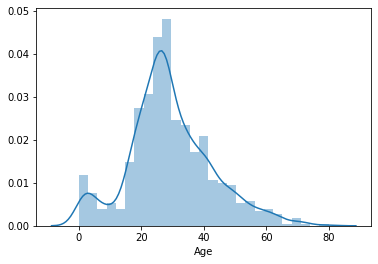

In [72]:
sns.distplot(df['Age'])

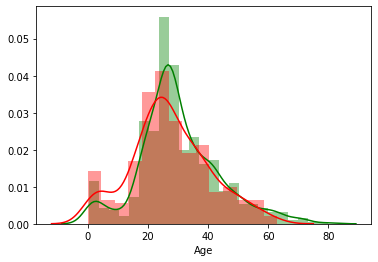

In [73]:
sns.distplot(df[df['Sex'] == 'male']['Age'], color='green')
sns.distplot(df[df['Sex'] == 'female']['Age'], color='red')

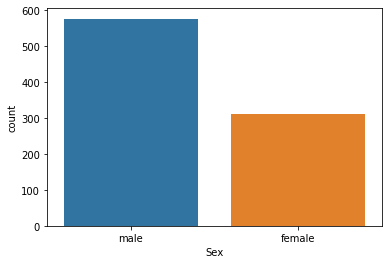

In [74]:
sns.countplot(x='Sex', data=df)

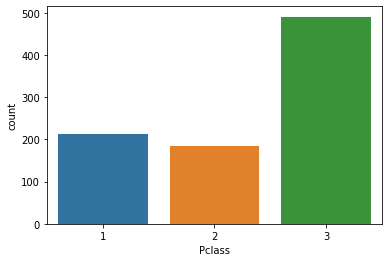

In [75]:
sns.countplot(x='Pclass', data=df)

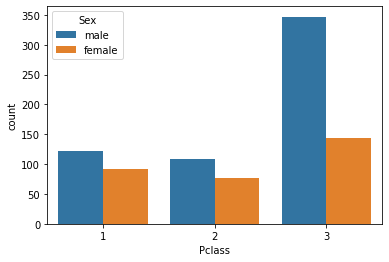

In [76]:
sns.countplot(x='Pclass', data=df, hue='Sex')

Note:<br>

1. Majority of passengers are in class-3
1. There are more male passengers than female passengers

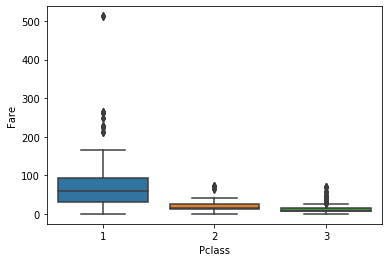

In [77]:
sns.boxplot(x='Pclass', y='Fare', data=df)

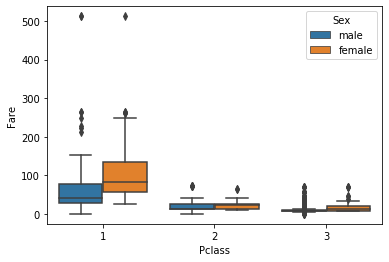

In [78]:
sns.boxplot(x='Pclass', y='Fare',hue='Sex', data=df)

Note:<br>

1. Class-1 ticket is the most expensive
1. Female's class-1 tickets usually more expensive than male's

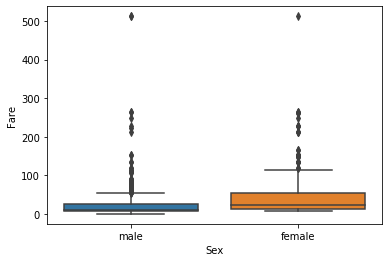

In [79]:
sns.boxplot(x='Sex', y='Fare', data=df)

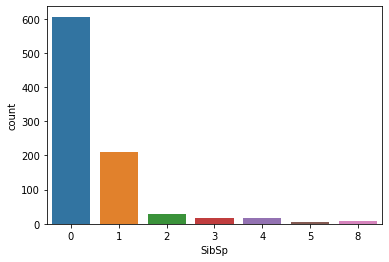

In [80]:
sns.countplot(x='SibSp', data=df)

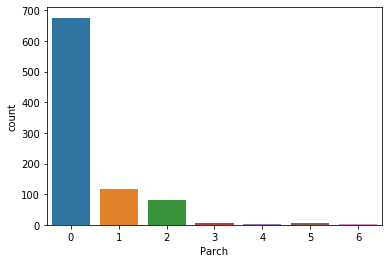

In [81]:
sns.countplot(x='Parch', data=df)

Majority of passengers did not bring their family

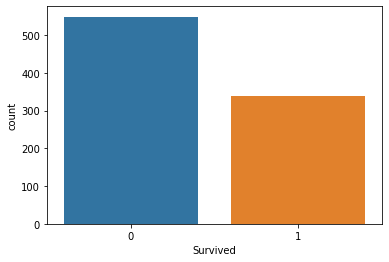

In [82]:
sns.countplot(x='Survived', data=df)

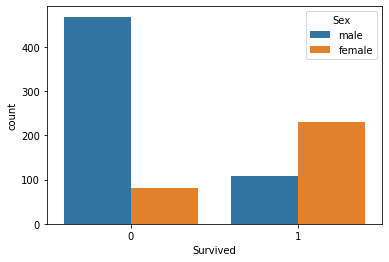

In [83]:
sns.countplot(x='Survived', data=df, hue='Sex')

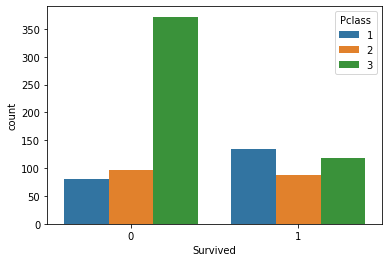

In [84]:
sns.countplot(x='Survived', data=df, hue='Pclass')

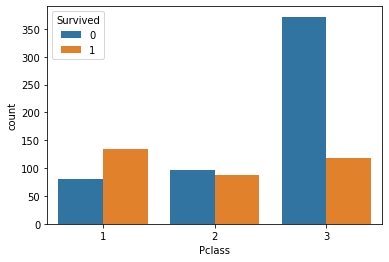

In [85]:
sns.countplot(x='Pclass', data=df, hue='Survived')

Note:<br>

1. Female has higher survival chance than male
1. Class-1 passenger has higher survival chance than other classes

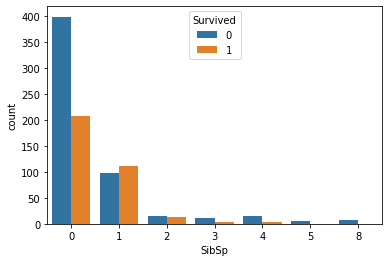

In [86]:
sns.countplot(x='SibSp', data=df, hue='Survived')

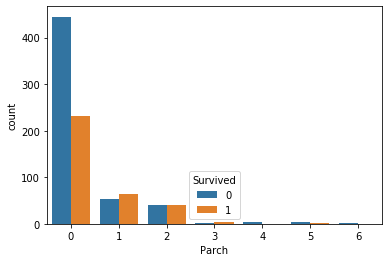

In [87]:
sns.countplot(x='Parch', data=df, hue='Survived')

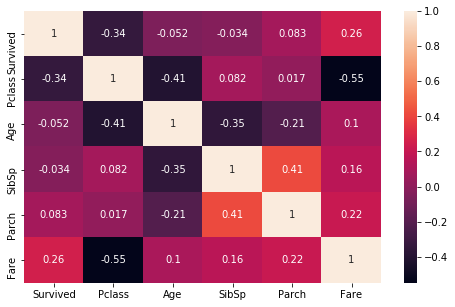

In [88]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), annot=True)

Fare and Pclass have more impact on survivability

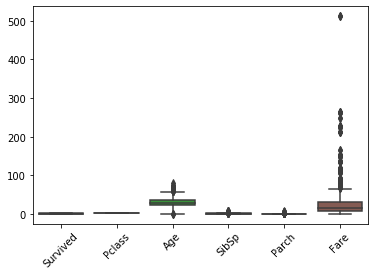

In [89]:
#plt.figure(figsize = (30,10))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()

### 3. Modelling

Let's build our model with Random Forest and XGBoost

In [90]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,M,S
2,1,1,female,38.000000,1,0,71.2833,C,C
3,1,3,female,26.000000,0,0,7.9250,M,S
4,1,1,female,35.000000,1,0,53.1000,C,S
5,0,3,male,35.000000,0,0,8.0500,M,S
6,0,3,male,28.813088,0,0,8.4583,M,Q
7,0,1,male,54.000000,0,0,51.8625,E,S
8,0,3,male,2.000000,3,1,21.0750,M,S
9,1,3,female,27.000000,0,2,11.1333,M,S


In [91]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,1,0,0,0,0,0,0,1,0,0,1
2,1,1,38.000000,1,0,71.2833,0,0,1,0,0,0,0,0,0,0,0
3,1,3,26.000000,0,0,7.9250,0,0,0,0,0,0,0,1,0,0,1
4,1,1,35.000000,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,1
5,0,3,35.000000,0,0,8.0500,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,0,0,13.0000,1,0,0,0,0,0,0,1,0,0,1
888,1,1,19.000000,0,0,30.0000,0,1,0,0,0,0,0,0,0,0,1
889,0,3,20.059733,1,2,23.4500,0,0,0,0,0,0,0,1,0,0,1


Now we split the data

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [93]:
data = df_ohe.drop(['Survived'], axis=1)
target = df_ohe['Survived']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=101, test_size=0.3)

Now we train it

**Random Forest**

In [95]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [96]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [97]:
print(classification_report(y_train, rfc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       386
           1       1.00      0.99      0.99       236

    accuracy                           0.99       622
   macro avg       0.99      0.99      0.99       622
weighted avg       0.99      0.99      0.99       622



In [98]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       163
           1       0.79      0.74      0.77       104

    accuracy                           0.82       267
   macro avg       0.82      0.81      0.81       267
weighted avg       0.82      0.82      0.82       267



**GridSearchCV Random Forest**

In [158]:
search_rf = GridSearchCV(estimator = rfc,
                     param_grid = {
                         'max_depth' : [5, 10, 15],
                         'n_estimators' : [60, 80, 100, 120],
                         'min_samples_split' : [2, 5, 10, 20]
                     },scoring = 'roc_auc',
                     cv = 15,
                     n_jobs = -1)

In [159]:
search_rf.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [60, 80, 100, 120]},
             scoring='roc_auc')

In [160]:
print(classification_report(y_test, search_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       163
           1       0.84      0.76      0.80       104

    accuracy                           0.85       267
   macro avg       0.85      0.83      0.84       267
weighted avg       0.85      0.85      0.85       267



**XGBoost**

In [103]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [104]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
print(classification_report(y_train, xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       386
           1       0.99      0.98      0.99       236

    accuracy                           0.99       622
   macro avg       0.99      0.99      0.99       622
weighted avg       0.99      0.99      0.99       622



In [106]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       163
           1       0.79      0.74      0.76       104

    accuracy                           0.82       267
   macro avg       0.81      0.81      0.81       267
weighted avg       0.82      0.82      0.82       267



**GridSearchCV XGBoost**

In [161]:
search_xgb = GridSearchCV(estimator = xgb,
                     param_grid = {
                         'max_depth' : [3, 5, 7],
                         'eta' : [0.01, 0.05, 0.1, 0.2],
                         'subsample' : [0.4, 0.6, 0.8]
                     },scoring = 'roc_auc',
                     cv = 15,
                     n_jobs = -1)

In [162]:
search_xgb.fit(X_train, y_train)

GridSearchCV(cv=15,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [163]:
print(classification_report(y_test, search_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       163
           1       0.78      0.69      0.73       104

    accuracy                           0.81       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267



**ROC-AUC Scoring**

In [164]:
search_xgb.best_score_

0.8781848290598291

In [165]:
search_rf.best_score_

0.8730138888888889

**Predicting Real Test Data**

In [112]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,26.792872,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [114]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.9+ KB


In [117]:
df_test['Fare'].fillna(value=df_test['Fare'].median(), inplace=True)

In [119]:
df_test['Embarked'].fillna(value=df_test['Embarked'].mode(), inplace=True)

In [120]:
df_test['Cabin'].fillna(value='Missing', inplace=True)

In [121]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     418 non-null    object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.9+ KB


In [122]:
df_test['Cabin'] = df_test['Cabin'].apply(lambda x: x[0])

In [123]:
df_test['Cabin'].value_counts()

M    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In [126]:
df_test.drop(columns=['Name', 'Ticket'], axis=1, inplace=True)

In [127]:
df_test_ohe = pd.get_dummies(df_test, drop_first=True)
df_test_ohe

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,3,34.500000,0,0,7.8292,1,0,0,0,0,0,0,1,1,0
893,3,47.000000,1,0,7.0000,0,0,0,0,0,0,0,1,0,1
894,2,62.000000,0,0,9.6875,1,0,0,0,0,0,0,1,1,0
895,3,27.000000,0,0,8.6625,1,0,0,0,0,0,0,1,0,1
896,3,22.000000,1,1,12.2875,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,26.792872,0,0,8.0500,1,0,0,0,0,0,0,1,0,1
1306,1,39.000000,0,0,108.9000,0,0,1,0,0,0,0,0,0,0
1307,3,38.500000,0,0,7.2500,1,0,0,0,0,0,0,1,0,1


In [128]:
X_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
512,3,26.792872,0,0,8.05,1,0,0,0,0,0,0,1,0,0,1
614,3,28.807693,0,0,7.75,1,0,0,0,0,0,0,1,0,1,0
616,2,24.000000,1,2,65.00,0,0,0,0,0,0,0,1,0,0,1
338,1,41.000000,0,0,134.50,0,0,0,0,1,0,0,0,0,0,0
719,3,28.866721,0,0,15.50,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,3,-0.055520,8,2,69.55,0,0,0,0,0,0,0,1,0,0,1
829,3,28.807693,0,0,7.75,1,0,0,0,0,0,0,1,0,1,0
733,2,33.807958,0,0,0.00,1,0,0,0,0,0,0,1,0,0,1


In [136]:
x = df_test_ohe.copy()

In [137]:
x

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,3,34.500000,0,0,7.8292,1,0,0,0,0,0,0,1,1,0
893,3,47.000000,1,0,7.0000,0,0,0,0,0,0,0,1,0,1
894,2,62.000000,0,0,9.6875,1,0,0,0,0,0,0,1,1,0
895,3,27.000000,0,0,8.6625,1,0,0,0,0,0,0,1,0,1
896,3,22.000000,1,1,12.2875,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,26.792872,0,0,8.0500,1,0,0,0,0,0,0,1,0,1
1306,1,39.000000,0,0,108.9000,0,0,1,0,0,0,0,0,0,0
1307,3,38.500000,0,0,7.2500,1,0,0,0,0,0,0,1,0,1


In [138]:
x.insert(loc=13, column='Cabin_T', value=0)

In [139]:
x

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
892,3,34.500000,0,0,7.8292,1,0,0,0,0,0,0,1,0,1,0
893,3,47.000000,1,0,7.0000,0,0,0,0,0,0,0,1,0,0,1
894,2,62.000000,0,0,9.6875,1,0,0,0,0,0,0,1,0,1,0
895,3,27.000000,0,0,8.6625,1,0,0,0,0,0,0,1,0,0,1
896,3,22.000000,1,1,12.2875,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,26.792872,0,0,8.0500,1,0,0,0,0,0,0,1,0,0,1
1306,1,39.000000,0,0,108.9000,0,0,1,0,0,0,0,0,0,0,0
1307,3,38.500000,0,0,7.2500,1,0,0,0,0,0,0,1,0,0,1


In [140]:
submission = search_xgb.predict(x)

In [141]:
submission

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [142]:
df_submission = pd.DataFrame({
    'PassengerId': x.index,
    'Survived': submission
})

In [143]:
df_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [146]:
df_submission.to_csv(path_or_buf='hakim_submission.csv', index=False)

In [148]:
jajaj = pd.read_csv('submission.csv')
jajaj

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
